In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import imblearn

In [2]:
fraud_data = pd.read_csv("Fraud_Data.csv")
ip_address_to_country = pd.read_csv("IpAddress_to_Country.csv")

In [3]:
fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [4]:
ip_address_to_country.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [5]:
fraud_data.shape

(151112, 11)

In [6]:
ip_address_to_country.shape

(138846, 3)

In [7]:
lower = ip_address_to_country['lower_bound_ip_address']
upper = ip_address_to_country['upper_bound_ip_address']

In [8]:
# for ip_address in fraud_data['ip_address']:
#     country = ip_address_to_country[ip_address >= lower.values & ip_address <= upper.values].
countries = []
for ip_address in fraud_data['ip_address']:
    temp = ip_address_to_country[(ip_address>=lower.values) & (ip_address<=upper.values)].country.values
    if len(temp)>0:
        countries.append(temp[0])
    else:
        countries.append('no country')
    

In [9]:
len(countries)

151112

In [10]:
fraud_data['country'] = countries

In [11]:
#Question 1
fraud_data[['user_id','country']]

,user_id,country
0,22058,Japan
1,333320,United States
2,1359,United States
3,150084,no country
4,221365,United States
5,159135,Canada
6,50116,no country
7,360585,United States
8,159045,China
9,182338,United States


In [12]:
fraud_data.tail()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
151107,345170,2015-01-27 03:03:34,2015-03-29 00:30:47,43,XPSKTWGPWINLR,SEO,Chrome,M,28,3.451155e+09,1,United States
151108,274471,2015-05-15 17:43:29,2015-05-26 12:24:39,35,LYSFABUCPCGBA,SEO,Safari,M,32,2.439047e+09,0,Netherlands
151109,368416,2015-03-03 23:07:31,2015-05-20 07:07:47,40,MEQHCSJUBRBFE,SEO,IE,F,26,2.748471e+09,0,Japan
151110,207709,2015-07-09 20:06:07,2015-09-07 09:34:46,46,CMCXFGRHYSTVJ,SEO,Chrome,M,37,3.601175e+09,0,United States
151111,138208,2015-06-10 07:02:20,2015-07-21 02:03:53,20,ZINIADFCLHYPG,Direct,IE,M,38,4.103825e+09,0,no country


In [13]:
#step 1 — selecting features (chi-square test for relevant features)
print "unique # device id's: ", len(fraud_data['device_id'].unique())
print "unique # sources: ", len(fraud_data['source'].unique())
print "unique # browsers: ", len(fraud_data['browser'].unique())
print "unique # purchase values", len(fraud_data['purchase_value'].unique())
print "unique # ages", len(fraud_data['age'].unique())
print "unique # sign up times", len(fraud_data['signup_time'].unique())
print "unique # purchase times", len(fraud_data['purchase_time'].unique())
 

unique # device id's:  137956
unique # sources:  3
unique # browsers:  5
unique # purchase values 122
unique # ages 58
unique # sign up times 151112
unique # purchase times 150679


In [14]:
#visualizations + chisquare tests for the above to determine importance of features
not_frauds = fraud_data[fraud_data['class']==0]
frauds = fraud_data[fraud_data['class']==1]

feature_df = pd.DataFrame()
feature_df["features"]=frauds.columns
feature_df

,features
0,user_id
1,signup_time
2,purchase_time
3,purchase_value
4,device_id
5,source
6,browser
7,sex
8,age
9,ip_address


In [15]:
def hist_exploration(feature_name):
    plt.hist([not_frauds[feature_name], frauds[feature_name]], bins=30,normed=False, label=['not frauds', 'frauds'])
    plt.xlabel(feature_name)
    plt.ylabel('counts')
    plt.legend(loc='upper right')
    plt.show()

def bar_exploration(feature_name):
    width = 0.4
    not_fraud_bar = Counter(not_frauds[feature_name])
    fraud_bar = Counter(frauds[feature_name])
    x = np.arange(len(not_fraud_bar.values()))
    x1 = np.arange(len(fraud_bar.values()))
    plt.bar(x, not_fraud_bar.values(), width, label='not_frauds')
    plt.bar(x+width, fraud_bar.values(), width, label='frauds')
    plt.xticks(x, not_fraud_bar.keys())
    plt.xlabel(feature_name)
    plt.ylabel('count')
    plt.legend(loc='upper right')
    plt.show()    

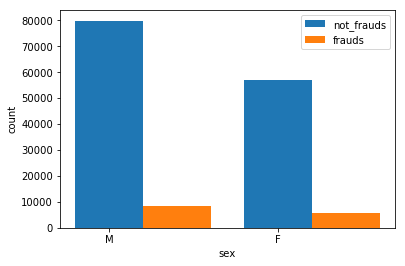

In [16]:
#distributions of sex
bar_exploration('sex')

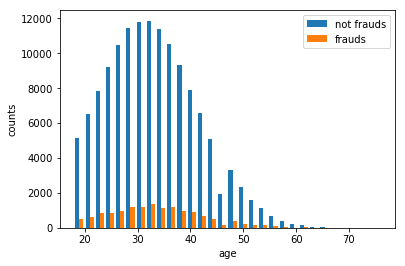

In [17]:
#distributions of age
hist_exploration('age')

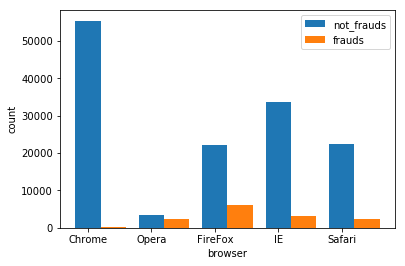

In [18]:
#distributions of browser
bar_exploration('browser')

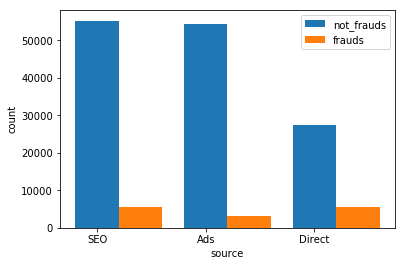

In [19]:
#distributions of source
bar_exploration('source')

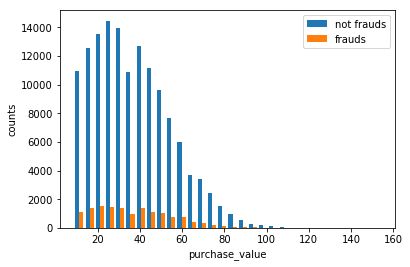

In [20]:
#distributions of purchase values
hist_exploration('purchase_value')

In [21]:
#distributions of countries
# why error --> bar_exploration('country')

In [22]:
#by intuition, device_id, signup_time, and purchase_time are unlikely to be 
#crucial to predicting fraud (distributions take too long to load)
#however, the difference between signup_time and purchase_time could be relevant to fraud detection
p = np.asarray([pd.to_datetime(i) for i in fraud_data['purchase_time'].values])
s = np.asarray([pd.to_datetime(i) for i in fraud_data['signup_time'].values])


In [23]:
diff_time = p-s
diff_time[:10]

array([Timedelta('52 days 03:51:22'), Timedelta('0 days 04:59:04'),
       Timedelta('0 days 00:00:01'), Timedelta('5 days 16:41:25'),
       Timedelta('50 days 11:31:01'), Timedelta('49 days 02:02:11'),
       Timedelta('25 days 04:57:05'), Timedelta('49 days 09:45:29'),
       Timedelta('41 days 14:23:20'), Timedelta('57 days 05:15:53')], dtype=object)

In [24]:
diff_time = np.asarray([i.total_seconds() for i in diff_time])

In [25]:
fraud_data['time_difference'] = diff_time

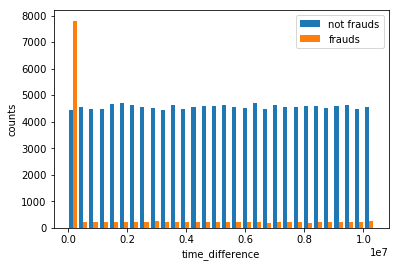

In [26]:
not_frauds = fraud_data[fraud_data['class']==0]
frauds = fraud_data[fraud_data['class']==1]
hist_exploration('time_difference')

In [27]:
from sklearn.feature_selection import chi2

#device_id, user_id takes too long (check if theyre significant later but intutitively, they shouldn't be)
#signup_time purchase time contained in time_difference
#ip_address is contained in country
cols_to_drop = ['class', 'signup_time', 'purchase_time', 'device_id', 'ip_address', 'user_id']
temp_data = fraud_data.drop(cols_to_drop, axis=1)
temp_data
cols_to_encode = ['source', 'browser', 'sex', 'country']
one_hot_data = pd.get_dummies(temp_data, columns=cols_to_encode)
one_hot_data.head()

,purchase_value,age,time_difference,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,...,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Venezuela,country_Viet Nam,country_Virgin Islands (U.S.),country_Yemen,country_Zambia,country_Zimbabwe,country_no country
0,34,39,4506682.0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,16,53,17944.0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,15,53,1.0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,44,41,492085.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,39,45,4361461.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [94]:
fraud_data.query('"class" == 1')

TypeError: argument of type 'int' is not iterable

In [28]:
one_hot_data.shape

(151112, 195)

In [29]:
fraud_data['class'].shape

(151112,)

In [30]:
#use chi2 to detect feature importance
chi2, p_value = chi2(one_hot_data, fraud_data['class'])

In [31]:
feature_chi2 = pd.DataFrame()
feature_chi2["features"] = one_hot_data.columns
feature_chi2["chi_2_values"] = chi2
feature_chi2["p_values"] = p_value

In [32]:
feature_chi2

,features,chi_2_values,p_values
0,purchase_value,1.404002e+00,2.360546e-01
1,age,1.485610e+01,1.160322e-04
2,time_difference,1.991514e+10,0.000000e+00
3,source_Ads,1.760882e+00,1.845146e-01
4,source_Direct,4.958058e+01,1.903890e-12
5,source_SEO,1.358172e+01,2.283994e-04
6,browser_Chrome,1.916962e+01,1.196017e-05
7,browser_FireFox,6.688420e-01,4.134556e-01
8,browser_IE,2.042492e+01,6.201705e-06
9,browser_Opera,8.454928e-01,3.578305e-01


In [33]:
feature_chi2.sort_values('chi_2_values')

,features,chi_2_values,p_values
105,country_Latvia,8.191379e-06,9.977164e-01
176,country_Trinidad and Tobago,1.941266e-03,9.648567e-01
22,country_Azerbaijan,1.212542e-02,9.123178e-01
72,country_Finland,2.181761e-02,8.825733e-01
55,country_Croatia (LOCAL Name: Hrvatska),2.362588e-02,8.778407e-01
143,country_Paraguay,2.594126e-02,8.720438e-01
88,country_Iceland,3.021233e-02,8.620093e-01
87,country_Hungary,3.218920e-02,8.576130e-01
158,country_Senegal,3.234524e-02,8.572720e-01
85,country_Honduras,3.234524e-02,8.572720e-01


In [39]:
# from the above, it's evident that time_difference, country, and source are the most
# important features when it comes to detecting fradulent activity (with browser and age trailing behind)


# step 2 - handling imbalanced classes
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state=42)
x_res, y_res = sm.fit_sample(one_hot_data,fraud_data['class'])


array([[  3.40000000e+01,   3.90000000e+01,   4.50668200e+06, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  1.60000000e+01,   5.30000000e+01,   1.79440000e+04, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  1.50000000e+01,   5.30000000e+01,   1.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       ..., 
       [  1.95719394e+01,   3.02859697e+01,   4.31595559e+06, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  4.10000000e+01,   3.60000000e+01,   1.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  2.90000000e+01,   3.00000000e+01,   1.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]])

In [40]:
x_res.shape

(273922, 195)

In [47]:
y_res.shape

(273922,)

In [48]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_res, y_res, test_size=0.2, random_state=0)


In [49]:
# step 3 classify data

# decision tree classifier

from sklearn.tree import DecisionTreeClassifier
decision_tree_classifier = DecisionTreeClassifier(random_state=0)

In [50]:
decision_tree_classifier.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')

In [51]:
y_predicted = decision_tree_classifier.predict(x_test)

In [56]:
#step 4 - analzye results
from sklearn.metrics import f1_score, classification_report, confusion_matrix
def metrics(y_test, y_predicted):
    print "f1 score is ", f1_score(y_test, y_predicted)
    print "confusion matrix is", confusion_matrix(y_test, y_predicted, labels=[0,1])
    print "classification report"
    print classification_report(y_test, y_predicted)

metrics(y_test, y_predicted)

f1 score is  0.948603494452
confusion matrix is [[25931  1515]
 [ 1306 26033]]
classification report              precision    recall  f1-score   support

          0       0.95      0.94      0.95     27446
          1       0.95      0.95      0.95     27339

avg / total       0.95      0.95      0.95     54785



In [84]:
# use random forest classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

random_forest_classifier = RandomForestClassifier(n_estimators=10, n_jobs=-1, class_weight="balanced", random_state=0)


In [85]:
random_forest_classifier.fit(x_train, y_train)
y_predicted = random_forest_classifier.predict(x_test)
metrics(y_test, y_predicted)

f1 score is  0.972289924632
confusion matrix is [[27377    69]
 [ 1409 25930]]
classification report              precision    recall  f1-score   support

          0       0.95      1.00      0.97     27446
          1       1.00      0.95      0.97     27339

avg / total       0.97      0.97      0.97     54785



In [86]:
cross_val_score(random_forest_classifier, x_train, y_train, n_jobs=-1, verbose=True, cv=10)

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   54.0s finished


array([ 0.97166324,  0.97316906,  0.97193575,  0.97335037,  0.97576891,
        0.97211701,  0.97207137,  0.97065669,  0.9747182 ,  0.97444439])

In [87]:
#determining hyperparameters for RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
parameters_to_test = {'max_depth':[5,10,15,20,25], 
                      'max_leaf_nodes':[5,10,15,20,25]}
#what does beta mean?
scorer = make_scorer(fbeta_score, beta=2)
grid = GridSearchCV(random_forest_classifier, parameters_to_test, scoring=scorer)


In [88]:
optimized_params = grid.fit(x_train, y_train)

In [89]:
print "best f1 score is", optimized_params.best_score_
print "which was gotten with the ff parameters ", optimized_params.best_params_

best f1 score is 0.919746145734
which was gotten with the ff parameters  {'max_leaf_nodes': 25, 'max_depth': 15}


In [90]:
# Question 2 — ans: model can be switched between decision tree classifier and random tree classifier (optimized with
# the code above); in terms of false negative and false positives, false negatives would be more detrimental
# to the e-commerce's business. Thus, recall should be prioritized as a scoring method (though the f1 score is used above)

# Question 3 —in terms of common features of fraudelent activity, one can consider the feature_chi_2 datafrane, which
# clearly shows certain features (and details) that make up fradulent activity. Without going into the mathematics of
# ensemble methods (in our case RandomForestClassifiers), the most importance indicators of fraudelent activity is
# diff time, country, source, and purchase_value

#Question 4 — in terms of product persepctive, since the model can be optimized (as shown above), it can simply
#be used with an incoming stream of user data. However, since the model is not perfect (seen by the f1 score, or more
# suitable to this situation, the recall score), the users predicted to be partaking in fraudelent activity shouldn't be
# locked out immediately (there's still the chance of false positives). Instead, the interface should require some 
# more auth, or perhaps place a flag on the user_id and if the model predicts that user_id partaking in fraudelent
# activity s.t. the probability of the model mistaking the activity multiple times is significantly low, then 
# the account should be placed on hold (or something of the sort).